In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle
import operator
from pylab import *
from sklearn.decomposition import PCA

In [2]:
import sys
sys.path.append("/opt/conda/lib/python3.7/site-packages") ##添加xbg路径
import woe.feature_process as fp
import woe.eval as eval

In [3]:
from time import time
import scipy.stats as stats
import gc

from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit, train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import log_loss, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import contextlib

In [4]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, RocCurveDisplay,auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [5]:
train2 = pd.read_csv('721train.csv',index_col=0)

In [6]:
dt = pd.read_csv('721dt.csv',index_col=0)

In [7]:
dt

,customer_wid,target,lastbuy_date_diff,thisyear_newsales,lastyear_newsales,thisyear_newbuycnt,lastyear_newbuycnt,cir_day,register_count_pv_15_pv,register_count_pv_30_pv,...,zps_endtrial_120_pv,zps_endtrial_15_uv,zps_endtrial_30_uv,zps_endtrial_60_uv,zps_endtrial_120_uv,lock_cnt_gtj,jkzh_ab,sgd_ab,zps_ab,jkzh_gjg
2,23185208,0,0.569168,0.403935,-0.410570,0.236641,-0.418181,-0.630646,-0.033373,-0.031403,...,-0.005933,-0.002441,-0.002003,-0.002961,-0.005933,-0.232855,8.890371e-09,-0.375459,-0.377916,0.079020
10,39065407,0,-0.369129,-0.633914,0.002712,-0.633914,-0.060616,-0.630646,-0.033373,-0.031403,...,-0.005933,-0.002441,-0.002003,-0.002961,-0.005933,-0.232855,8.890371e-09,-0.375459,-0.328416,0.079020
14,23476399,0,-0.369129,-0.633914,0.437992,-0.633914,-0.060616,-0.630646,-0.033373,-0.031403,...,-0.005933,-0.002441,-0.002003,-0.002961,-0.005933,0.158090,8.890371e-09,1.083090,0.946822,-0.374256
16,538795683,0,0.831476,-0.068518,0.002712,0.236641,-0.060616,0.278429,-0.033373,-0.031403,...,-0.005933,-0.002441,-0.002003,-0.002961,-0.005933,-0.232855,8.890371e-09,-0.375459,-0.377916,-0.374256
19,23199395,1,1.065428,1.446653,-0.410570,1.282493,-0.418181,0.711380,-0.033373,-0.031403,...,-0.005933,-0.002441,-0.002003,-0.002961,-0.005933,-0.907659,8.890371e-09,-0.375459,-0.377916,-0.374256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484891,23288115,1,-0.369129,-0.633914,0.002712,-0.633914,-0.060616,-0.630646,-0.033373,-0.031403,...,-0.005933,-0.002441,-0.002003,-0.002961,-0.005933,-0.907659,8.890371e-09,-0.136538,-0.328416,-0.374256
485042,144257786,1,0.569168,0.403935,0.121450,0.236641,1.050400,0.711380,-0.033373,-0.031403,...,-0.005933,-0.002441,-0.002003,-0.002961,-0.005933,-0.232855,8.890371e-09,-0.375459,0.203839,0.961847
485138,34928961,1,0.569168,-0.068518,-0.410570,0.236641,-0.418181,-0.630646,-0.033373,-0.031403,...,-0.005933,-0.002441,-0.002003,-0.002961,-0.005933,0.923418,8.890371e-09,-0.375459,0.946822,0.961847
485273,45717918,1,1.065428,0.509116,-0.410570,0.236641,-0.418181,-0.630646,-0.033373,-0.031403,...,-0.005933,-0.002441,-0.002003,-0.002961,-0.005933,0.923418,8.890371e-09,-0.375459,-0.377916,-0.374256


In [7]:
test = pd.read_csv('721test.csv',index_col=0)

In [9]:
sum(train2['target']==1)/len(train2)

0.10092895508956777

In [8]:
sum(dt['target']==1)/len(dt)

0.12386800996151234

In [9]:
sum(test['target']==1)/len(test)

0.002150267211568689

In [49]:
p1 = np.array([True]*30297 + [False]*49228)
p2 = np.array(list(test['target']==1))
p3 = p1 | p2
test = test.iloc[p3,:]

In [10]:
from time import time
import scipy.stats as stats

In [14]:
X_train=train2.drop(['target','customer_wid'],axis=1)
Y_train=train2['target']

In [35]:
#分类器使用 xgboost
clf1 = XGBClassifier()
 
#设定搜索的xgboost参数搜索范围，值搜索XGBoost的主要6个参数
param_dist = {
        'n_estimators':range(100,300,50),
        'max_depth':range(2,10,1),
        'learning_rate':np.linspace(0.01,0.1,10),
        'subsample':np.linspace(0.7,1.0,20),
        'colsample_bytree':np.linspace(0.5,0.98,10),
        'min_child_weight':range(1,5,1)
        }
 
#RandomizedSearchCV参数说明，clf1设置训练的学习器
#param_dist字典类型，放入参数搜索范围
#scoring = 'neg_log_loss'，精度评价方式设定为“neg_log_loss“
#n_iter=300，训练300次，数值越大，获得的参数精度越大，但是搜索时间越长
#n_jobs = -1，使用所有的CPU进行训练，默认为1，使用1个CPU
grid = RandomizedSearchCV(clf1,param_dist,cv = 3,scoring = 'roc_auc',n_iter=15,n_jobs = -1,verbose=2)

In [11]:
clf1 = XGBClassifier(n_estimators=50,max_depth=5,learning_rate=0.06,subsample=1.0,colsample_bytree=0.6066666666666667,min_child_weight=2)

In [36]:
#在训练集上训练
grid.fit(X_train,Y_train)
#返回最优的训练器
best_estimator = grid.best_estimator_
print(best_estimator)
#输出最优训练器的精度
print(grid.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6066666666666667, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.06000000000000001,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=8,
              max_leaves=0, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
0.8401998460699122


In [ ]:
#pca = PCA()  # 加载PCA算法，设置降维后主成分数目为2
#reduced_x = pca.fit_transform(x) 

In [37]:
######保存
best_estimator.save_model("model_new.ubj")

[CV] END colsample_bytree=0.7133333333333334, learning_rate=0.030000000000000006, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=0.7133333333333334, learning_rate=0.09000000000000001, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.731578947368421; total time= 1.4min
[CV] END colsample_bytree=0.7133333333333334, learning_rate=0.09000000000000001, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.731578947368421; total time= 1.4min
[CV] END colsample_bytree=0.9266666666666666, learning_rate=0.07, max_depth=2, min_child_weight=1, n_estimators=250, subsample=0.8894736842105263; total time= 1.7min
[CV] END colsample_bytree=0.7666666666666666, learning_rate=0.05000000000000001, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8736842105263158; total time=  50.5s
[CV] END colsample_bytree=0.7666666666666666, learning_rate=0.05000000000000001, max_depth=3, min_child_weight=1, n_estimators

In [41]:
best_estimator=XGBClassifier()

In [42]:
best_estimator.load_model("model_new.ubj")

In [16]:
clf1.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6066666666666667, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.06, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [18]:
Y_train_pred = clf1.predict_proba(X_train)
Y_train_pred_1 = Y_train_pred[:,1]

In [20]:
X_dt=dt.drop(['target','customer_wid'],axis=1)
Y_dt=dt['target']
Y_dt_pred = clf1.predict_proba(X_dt)
Y_dt_pred_1 = Y_dt_pred[:,1]

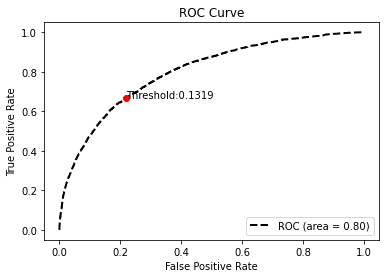

In [21]:
###最佳阈值
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

###ROC
fpr, tpr, thersholds = roc_curve(Y_dt, Y_dt_pred_1, pos_label=1)
best_thershold, point = Find_Optimal_Cutoff(tpr, fpr, thersholds)
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.plot(point[0], point[1], marker='o', color='r')
plt.text(point[0], point[1], f'Threshold:{best_thershold:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [52]:
roc_auc

0.8198543235338568

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

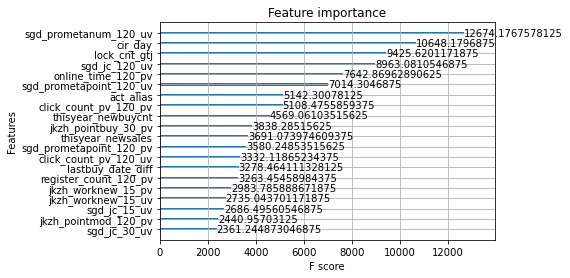

In [24]:
xgb.plot_importance(clf1,max_num_features=20,importance_type='cover')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

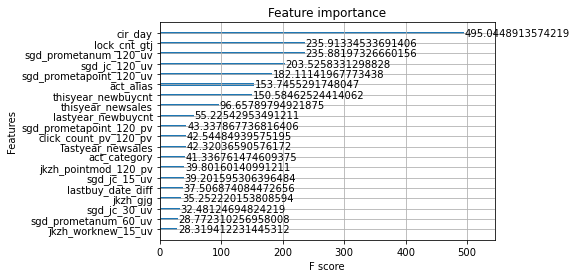

In [25]:
xgb.plot_importance(clf1,max_num_features=20,importance_type='gain')

(array([0.7135425 , 0.7135425 , 0.7135425 , 0.86803401, 0.86803401,
        0.92885198, 0.92885198, 0.92885198, 0.92885198, 1.        ]),
 array([-0.63064592, -0.38405371, -0.13746149,  0.10913072,  0.35572293,
         0.60231515,  0.84890736,  1.09549958,  1.34209179,  1.588684  ,
         1.83527622]),
 [<matplotlib.patches.Polygon at 0x7fca3adcde10>])

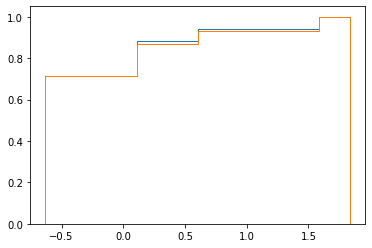

In [81]:
###Cir day
hist(test2['cir_day'],cumulative=True,histtype='step',density=True)
hist(train2['cir_day'],cumulative=True,histtype='step',density=True,label = "7.18")

In [36]:
p1 = np.array([True]*15000 + [False]*69421)
p2 = np.array(list(test2['target']==1))

In [37]:
p3 = p1 | p2

In [38]:
test2 = test2.iloc[p3,:]

In [39]:
sum(test2['target'])/15000

0.29146666666666665

In [51]:
X_test=test.drop(['target','customer_wid'],axis=1)
Y_test=test['target']

In [52]:
Y_test_pred = best_estimator.predict_proba(X_test)

In [53]:
Y_test_pred_1 = Y_test_pred[:,1]

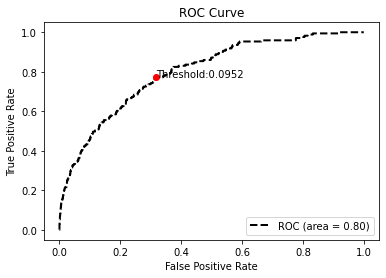

In [54]:
###最佳阈值
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

###ROC
fpr, tpr, thersholds = roc_curve(Y_test, Y_test_pred_1, pos_label=1)
best_thershold, point = Find_Optimal_Cutoff(tpr, fpr, thersholds)
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.plot(point[0], point[1], marker='o', color='r')
plt.text(point[0], point[1], f'Threshold:{best_thershold:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [55]:
roc_auc

0.8001425952529517

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

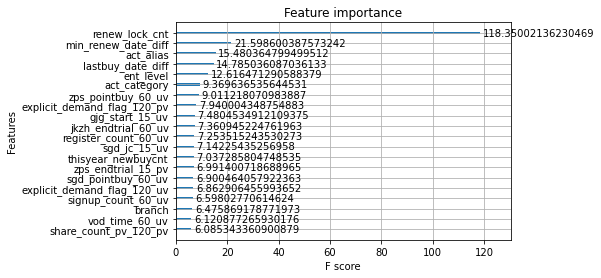

In [45]:
xgb.plot_importance(best_estimator,max_num_features=20,importance_type='gain')

In [46]:
weight = pd.Series(best_estimator.get_booster().get_score(importance_type='gain')).sort_values(ascending=False).head(20)
weight

renew_lock_cnt                 118.350021
min_renew_date_diff             21.598600
act_alias                       15.480365
lastbuy_date_diff               14.785036
ent_level                       12.616471
act_category                     9.369637
zps_pointbuy_60_uv               9.011218
explicit_demand_flag_120_pv      7.940004
gjg_start_15_uv                  7.480453
jkzh_endtrial_60_uv              7.360945
register_count_60_uv             7.253515
sgd_jc_15_uv                     7.142254
thisyear_newbuycnt               7.037286
zps_endtrial_15_pv               6.991401
sgd_pointbuy_60_uv               6.900464
explicit_demand_flag_120_uv      6.862906
signup_count_60_uv               6.598028
branch                           6.475869
vod_time_60_uv                   6.120877
share_count_pv_120_pv            6.085343
dtype: float64

[CV] END colsample_bytree=0.7133333333333334, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.7; total time=  23.9s
[CV] END colsample_bytree=0.7133333333333334, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.7; total time=  23.5s
[CV] END colsample_bytree=0.7666666666666666, learning_rate=0.020000000000000004, max_depth=9, min_child_weight=1, n_estimators=200, subsample=0.763157894736842; total time= 1.1min
[CV] END colsample_bytree=0.7133333333333334, learning_rate=0.1, max_depth=2, min_child_weight=4, n_estimators=100, subsample=0.9842105263157894; total time=   7.2s
[CV] END colsample_bytree=0.7133333333333334, learning_rate=0.1, max_depth=2, min_child_weight=4, n_estimators=100, subsample=0.9842105263157894; total time=   7.5s
[CV] END colsample_bytree=0.7133333333333334, learning_rate=0.1, max_depth=2, min_child_weight=4, n_estimators=100, subsample=0.9842105263157894; total time=   7.2s
[CV] END colsample_byt

In [69]:
#########
#####样本分布程度
from scipy.stats import ks_2samp
ks_2samp(train2.iloc[:,1],test2.iloc[:,1]).pvalue

5.790906765735834e-40

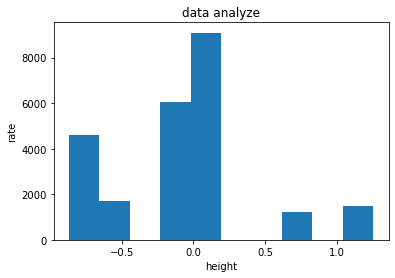

In [81]:
plt.hist(train2.iloc[:,2],bins=10)
plt.title("data analyze")
plt.xlabel("height")
plt.ylabel("rate")
 
plt.show()

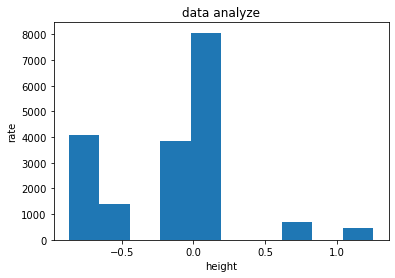

In [82]:
plt.hist(test2.iloc[:,2],bins=10)
plt.title("data analyze")
plt.xlabel("height")
plt.ylabel("rate")
 
plt.show()

In [4]:
base_data=spark.read.option("header","true").csv("/tmp/base_ad20230721.csv").toPandas()

23/07/24 01:28:10 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 3 were expected.
23/07/24 01:28:12 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/07/24 01:28:12 ERROR net.ScriptBasedMapping: Script /usr/hdp/3.1.4.0-315/hadoop/conf/topology_script.py returned 1 values when 23 were expected.
ERROR:root:Exception while sending command.                                     
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gat

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:45478)

In [2]:
import sys
sys.path.append('/data/gtair/tools/DWH')
from GlodonSparkSession3 import GlodonSparkSession
import os

In [3]:
spark = GlodonSparkSession().getSparkSession(log_lev='ERROR',resource_lev='high')

===============>app_name: gaokx_high_620502111
=====================>resource_lev: high


23/07/24 01:27:32 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/24 01:27:33 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/07/24 01:27:34 WARN shortcircuit.DomainSocketFactory: The short-circuit local reads feature cannot be used because libhadoop cannot be loaded.
23/07/24 01:27:34 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
23/07/24 01:27:46 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
23/07/24 01:27:46 WARN cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


In [38]:
?best_estimator

Type:        XGBClassifier
String form:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
           colsample_bylevel=1 <...> _parallel_tree=1, predictor='auto', random_state=0,
           reg_alpha=0, reg_lambda=1, ...)
File:        /opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py
Docstring:  
Implementation of the scikit-learn API for XGBoost classification.


Parameters
----------

    n_estimators : int
        Number of boosting rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[